In [79]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,GridSearchCV,cross_val_score

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression  

from sklearn.metrics import(roc_auc_score,plot_confusion_matrix,
                            confusion_matrix, classification_report)

from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence

import matplotlib.pyplot as plt

random_state=42

In [80]:
df=pd.read_csv('./data/churn.csv').drop(columns=['RowNumber','Surname', 'CustomerId', 'Geography'], axis=1)
df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,Female,42,8,159660.80,3,1,0,113931.57,1


In [81]:
df['Gender']=df['Gender'].apply(lambda x: 0 if x=='Female' else 1)

In [82]:
y = df["Exited"]
X = df.drop(["Exited"], axis = 1)

In [83]:
# count examples in each class
from collections import Counter
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 3.909


In [84]:
model = RandomForestClassifier(random_state=23,n_estimators=100,
                            oob_score=True)
model.fit(X, y)
model.oob_score_

0.8527

# Which customer attributes are more predictive of churn?

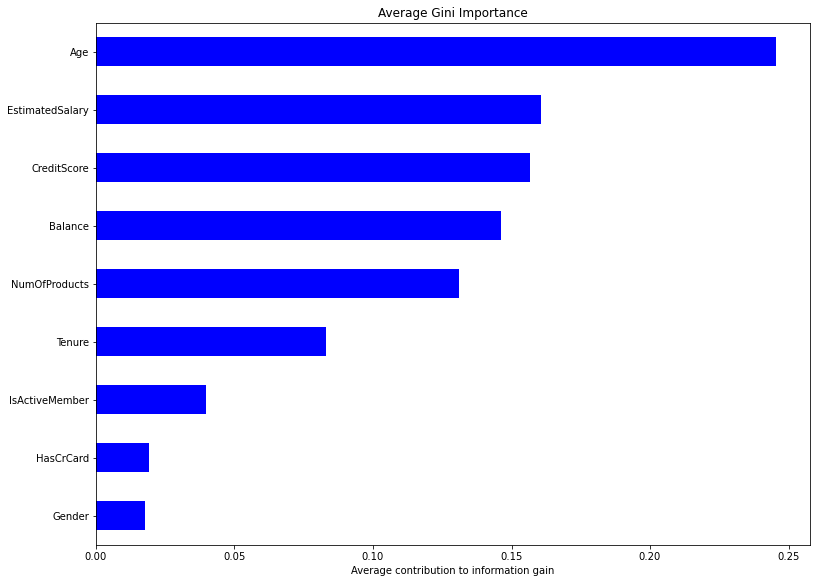

In [85]:
# Plot the feature importance
feat_scores = pd.Series(model.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(6.4*2,4.8*2),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')
plt.show()

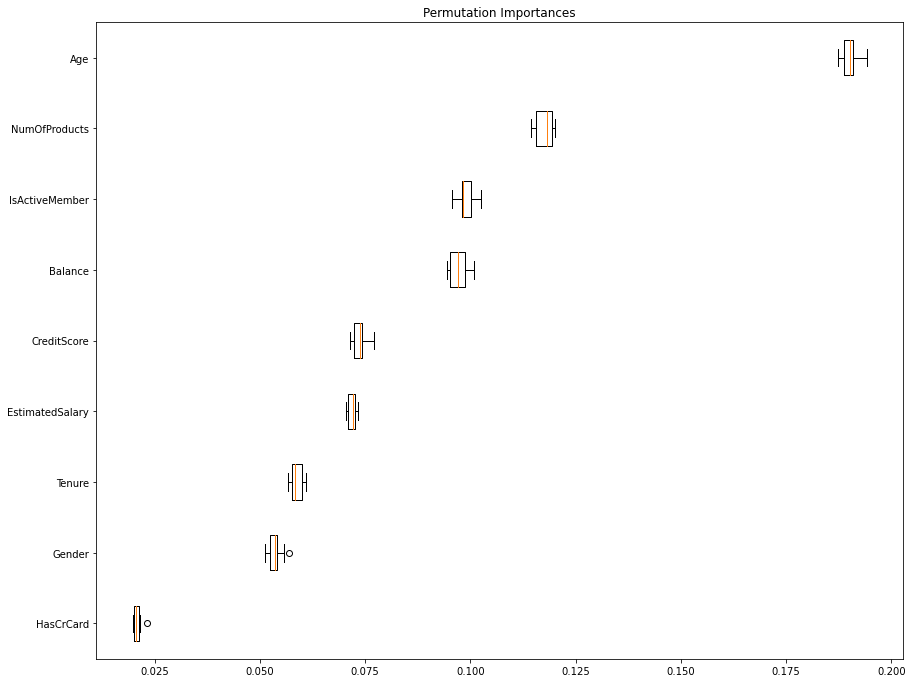

In [86]:
result = permutation_importance(model, X, y, n_repeats=10,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(6.4*2,4.8*2), tight_layout=True)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances")
plt.show()

/Users/grobovee/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


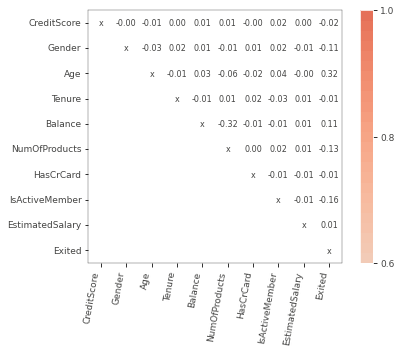

In [63]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(df, figsize=(7,5))
viz.view()

## Data preproccesing

In [87]:
cols=['Age','NumOfProducts','Balance','IsActiveMember']
X=X[cols]
y=y

In [88]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [89]:
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=23)

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.fit_transform(X_train)#fit_train set scaled
X_val=scaler.transform(X_val)#validation set scaled
X_test=scaler.transform(X_test)#holdout dataset scaled

## Random Forest

In [91]:
# define model
model = RandomForestClassifier(random_state=101)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.5f' % mean(scores))
print("Mean ROC AUC: %.5f " % (scores.mean()))

Mean ROC AUC: 0.80024 


In [92]:
# define grid
param_grid= {'n_estimators':[100,200,500],'max_depth':[3,5,9],'max_samples':[0.5,0.7,0.9]}
model =RandomForestClassifier(random_state=45)

In [93]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.848166 using {'max_depth': 5, 'max_samples': 0.5, 'n_estimators': 500}


## Validation set

In [94]:
model= RandomForestClassifier(n_estimators=500, max_depth=5, max_samples=0.5, random_state=44)
model.fit(X_train, y_train)
y_hat=model.predict(X_val)
rf_proba=model.predict_proba(X_val)
# rf_probs=rf_proba[:,1]

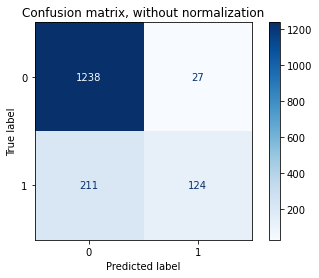

In [95]:
disp = plot_confusion_matrix(model, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

**Total error=16.5%, percentage of missed customers=25.5%, Specificity=97.0%, Sencitivity=74.4%**

In [96]:
decision_threshold=0.55
rf_probs=(rf_proba[:,1]>decision_threshold)

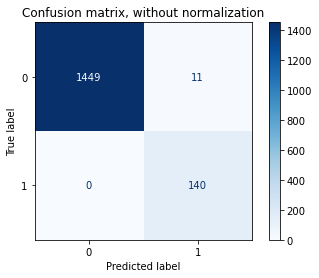

In [97]:
disp = plot_confusion_matrix(model, X_val, rf_probs,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

**Total error=1.0%, percentage of missed customer=10.6%,Specificity=98,7%, Sensitivity=87.5%**

In [98]:
rf_class_report=classification_report(y_val, rf_probs, digits=2)
print(rf_class_report)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1265
           1       0.86      0.36      0.51       335

    accuracy                           0.85      1600
   macro avg       0.85      0.67      0.71      1600
weighted avg       0.85      0.85      0.83      1600



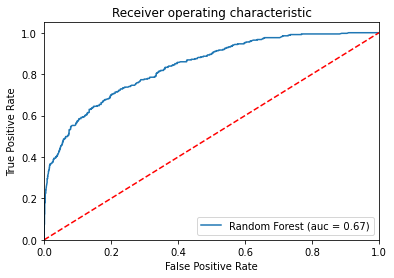

In [99]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc = roc_auc_score(y_val, model.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val,model.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (auc = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

## Test set

In [51]:
model.fit(X_train, y_train)
y_hat=model.predict(X_test)
rf_proba=model.predict_proba(X_test)

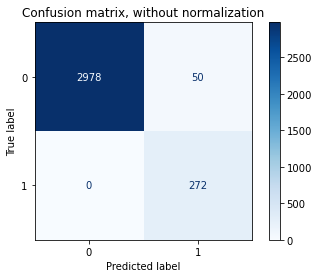

In [52]:
decision_threshold=0.55
rf_probs=(rf_proba[:,1]>decision_threshold)
disp = plot_confusion_matrix(model, X_test, rf_probs,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

In [53]:
rf_class_report=classification_report(y_test, rf_probs, digits=2)
print(rf_class_report)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2657
           1       0.83      0.35      0.49       643

    accuracy                           0.86      3300
   macro avg       0.85      0.67      0.71      3300
weighted avg       0.86      0.86      0.84      3300



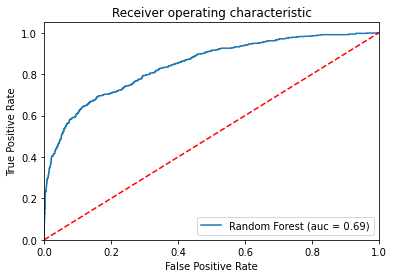

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (auc = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()